# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\Gaurav\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 120000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (120000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(103932, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

86.61

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(103930, 10)


1    87254
0    16676
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
I really enjoy the flavor of these torrincini.  But be aware, that 1/3 of the package is the traditional 'hard' torrone.  And when they say hard, they mean it.  I'm not a big fan of the hard variety, but their soft and chocolate versions are extremely tasty.
This is a great vanilla and I always use it when I'm baking something with more expensive ingredients or that I'm serving to people.  I don't waste this on my smoothies, etc - for that, I use the medium priced vanilla.
The actual product deserves 5 stars, the reason I gave it 4 stars is because its like three dollars at asianfoodgrocer.com. That's where I order it from, not amazon. Much lower prices.


In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
I really enjoy the flavor of these torrincini.  But be aware, that 1/3 of the package is the traditional 'hard' torrone.  And when they say hard, they mean it.  I'm not a big fan of the hard variety, but their soft and chocolate versions are extremely tasty.
This is a great vanilla and I always use it when I'm baking something with more expensive ingredients or that I'm serving to people.  I don't waste this on my smoothies, etc - for that, I use the medium priced vanilla.
The actual product deserves 5 stars, the reason I gave it 4 stars is because its like three dollars at asianfoodgrocer.com. That's where I order it from, not amazon. Much lower prices.


In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is a great vanilla and I always use it when I am baking something with more expensive ingredients or that I am serving to people.  I do not waste this on my smoothies, etc - for that, I use the medium priced vanilla.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is a great vanilla and I always use it when I am baking something with more expensive ingredients or that I am serving to people I do not waste this on my smoothies etc for that I use the medium priced vanilla 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 103930/103930 [04:28<00:00, 386.38it/s]


In [23]:
preprocessed_reviews[1500]

'great vanilla always use baking something expensive ingredients serving people not waste smoothies etc use medium priced vanilla'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


In [25]:
final['CleanedText']=preprocessed_reviews

In [26]:
#Create Train/Test Split of data (based on time, as we have sorted data already)

Train_data=final.iloc[0:60000]
print("Train data dim :",Train_data.shape)

CV_data=final.iloc[60000:80000]
print("CV data dim :",CV_data.shape)

Test_data=final.iloc[80000:]
print("Test data dim :",Test_data.shape)

Train data dim : (60000, 11)
CV data dim : (20000, 11)
Test data dim : (23930, 11)


In [27]:
## Our target variable i.e. review polarity with values 'positive'and 'negative'
Y_train_Polarity=Train_data['Score'].values

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score,auc
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,roc_curve

In [29]:
from sklearn.tree import DecisionTreeClassifier as DCT

In [30]:
from sklearn.model_selection import GridSearchCV,PredefinedSplit

In [31]:
from sklearn import tree

# [5] Assignment 8: Decision Trees

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Decision Trees

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [32]:
# Create BOW with Train data
count_vect=CountVectorizer(dtype='float')
vocab=count_vect.fit(Train_data['CleanedText'].values) ## Create Vocabulary to be used by Train and Test Data
Train_counts=count_vect.transform(Train_data['CleanedText'].values)
Train_counts.get_shape()

(60000, 45851)

In [33]:
# Fit our BOW vectorizer on CV data
CV_counts=count_vect.transform(CV_data['CleanedText'].values)
CV_counts.get_shape()

(20000, 45851)

In [34]:
# Fit our BOW vectorizer on test data
Test_counts=count_vect.transform(Test_data['CleanedText'].values)
Test_counts.get_shape()

(23930, 45851)

In [35]:
max_depth=[1, 5, 10, 50, 100, 500, 100]
min_samples_split =[5, 10, 100, 500]

###### Find optimal DT parameters i.e. max depth and min samples split

In [40]:
def find_optimal_dt_params(train_data,y_train,cv_data,y_cv,max_depth,min_split):
    '''
    This function is used to find optimal max depth and min samples split for our
    decision tree classifier.
    '''
    train_auc=[]
    val_auc=[]
    mdepth=[]
    msplit=[]
    for md in tqdm(max_depth):
        for ms in min_split:
            dt_clf=DCT(max_depth=md,min_samples_split=ms)
            dt_clf.fit(train_data,y_train)
            cv_predict=dt_clf.predict_proba(cv_data)
            train_predict=dt_clf.predict_proba(train_data)
            auc_score=roc_auc_score(y_cv,cv_predict[:,1])
            auc_score_train=roc_auc_score(y_train,train_predict[:,1])
            mdepth.append(md)
            msplit.append(ms)
            val_auc.append(auc_score)
            train_auc.append(auc_score_train)
    return mdepth,msplit,train_auc,val_auc
            

In [41]:
optimal_depth,optimal_split,train_auc,optimal_auc=find_optimal_dt_params(Train_counts,Y_train_Polarity,CV_counts,CV_data['Score'].values,max_depth,min_samples_split)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [44:08<00:00, 487.50s/it]


In [42]:
def plot_metric(optimal_depth,optimal_split,optimal_auc):
    val_dict={'Depth':optimal_depth,'Split':optimal_split,'AUC':optimal_auc}
    val_df=pd.DataFrame(val_dict)
    val_df_pivot=val_df.pivot_table(index='Depth',columns='Split',values='AUC')
    sns.heatmap(val_df_pivot,annot=True)
    plt.xlabel('Min Samples Split')
    plt.ylabel('Max Depth of Tree')
    plt.title('Finding Optimal Tree Parameters using AUC')
    plt.show()
    

For CV Data


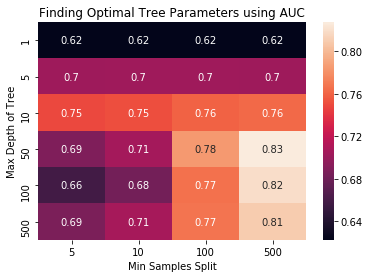

-----------------------------------------------------------------
For Train Data


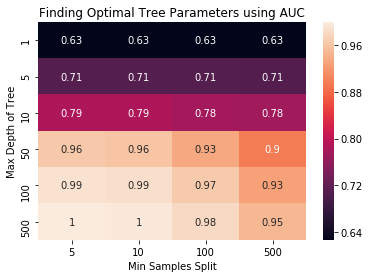

In [44]:
print('For CV Data')
plot_metric(optimal_depth,optimal_split,optimal_auc)
print('-----------------------------------------------------------------')
print('For Train Data')
plot_metric(optimal_depth,optimal_split,train_auc)

######  Fit DT model with Optimal Parameters on Test data

In [60]:
dt_clf=DCT(max_depth=50,min_samples_split=500)
dt_clf.fit(Train_counts,Y_train_Polarity)
predicted_test_class=dt_clf.predict(Test_counts)
test_predict=dt_clf.predict_proba(Test_counts)
actual_test=Test_data['Score'].values
predicted_test=test_predict[:,1]
predicted_test_class=dt_clf.predict(Test_counts)

In [61]:
test_roc=roc_auc_score(actual_test,predicted_test)
print('Test AUC:',test_roc)

Test AUC: 0.8278663163357445


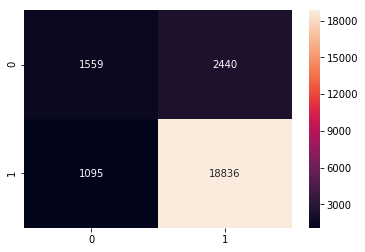

In [62]:
## Plot Confusion Matrix

cm=confusion_matrix(actual_test, predicted_test_class)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d"); #annot=True to annotate cells

In [63]:
fpr,tpr,_=roc_curve(actual_test,predicted_test)

In [64]:
## ROC- AUC Plot
def roc_auc_plot(fpr,tpr,test_roc):
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % test_roc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic -Test Data')
    plt.legend(loc="lower right")
    plt.show()

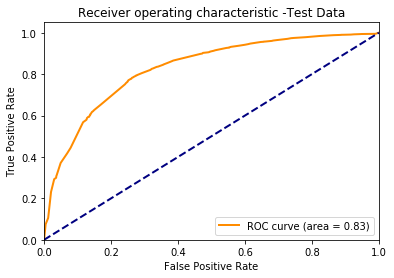

In [65]:
roc_auc_plot(fpr,tpr,test_roc)

In [66]:
imp_feat=dt_clf.feature_importances_

### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [67]:
sorted(zip(imp_feat, count_vect.get_feature_names()), reverse=True)[:20]

[(0.10631665500772203, 'not'),
 (0.059628590618250515, 'great'),
 (0.046264499070221565, 'disappointed'),
 (0.04118965111689237, 'worst'),
 (0.03907211129950547, 'money'),
 (0.030569746780957776, 'best'),
 (0.025337458635307657, 'delicious'),
 (0.020995238421469765, 'threw'),
 (0.019720247102165373, 'good'),
 (0.01832595316977654, 'love'),
 (0.018294017126194387, 'perfect'),
 (0.017054114897813322, 'bad'),
 (0.016321731277578102, 'awful'),
 (0.016283303666649068, 'return'),
 (0.01605644789044876, 'waste'),
 (0.014512462195129729, 'horrible'),
 (0.014275194257477997, 'loves'),
 (0.012789501968038441, 'terrible'),
 (0.009513222525403436, 'disappointing'),
 (0.009150182348486594, 'excellent')]

### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

In [56]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [70]:
from IPython.display import SVG
from graphviz import Source
from IPython.display import display                              
from ipywidgets import interactive

In [71]:
dt_clf=DCT(max_depth=5,min_samples_split=500)
dt_clf.fit(Train_counts,Y_train_Polarity)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [72]:
graph = Source(tree.export_graphviz(dt_clf
      , out_file=None
      , feature_names=count_vect.get_feature_names()
      , class_names=['Negative', 'Positive']
      , filled = True))

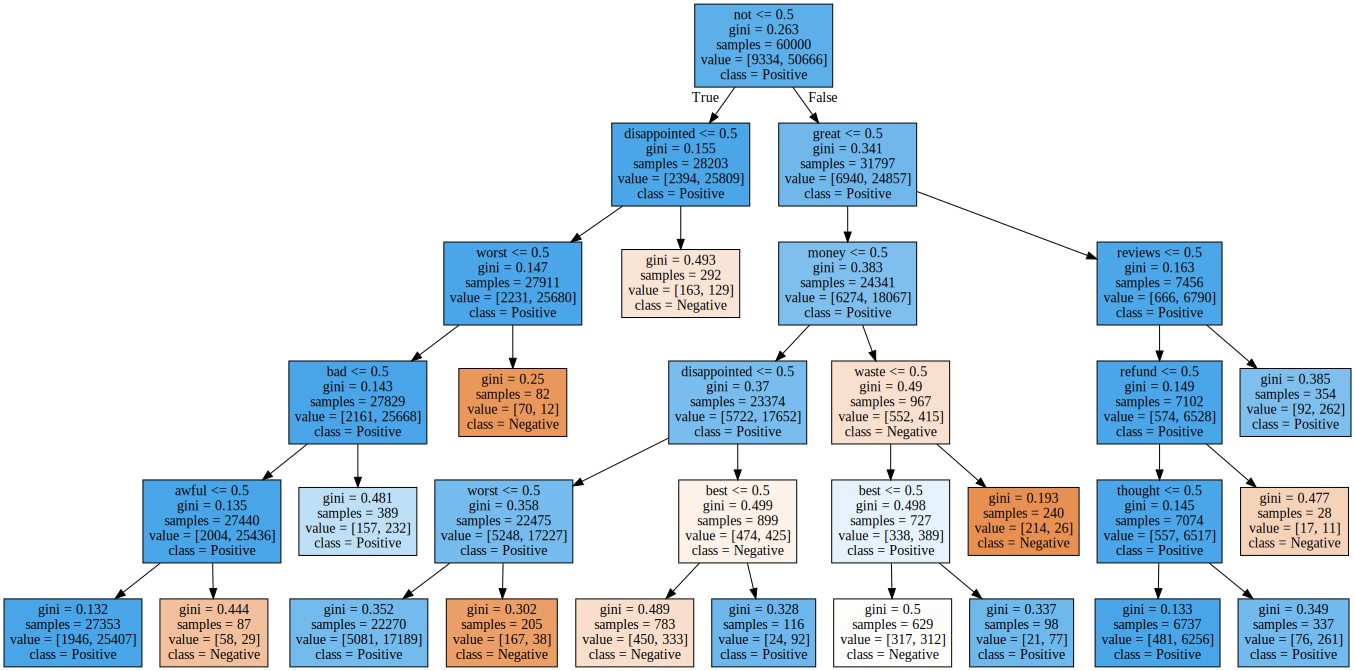

In [73]:
display(SVG(graph.pipe(format='svg')))

In [74]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [75]:
dot_data = StringIO()

In [76]:
export_graphviz(dt_clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

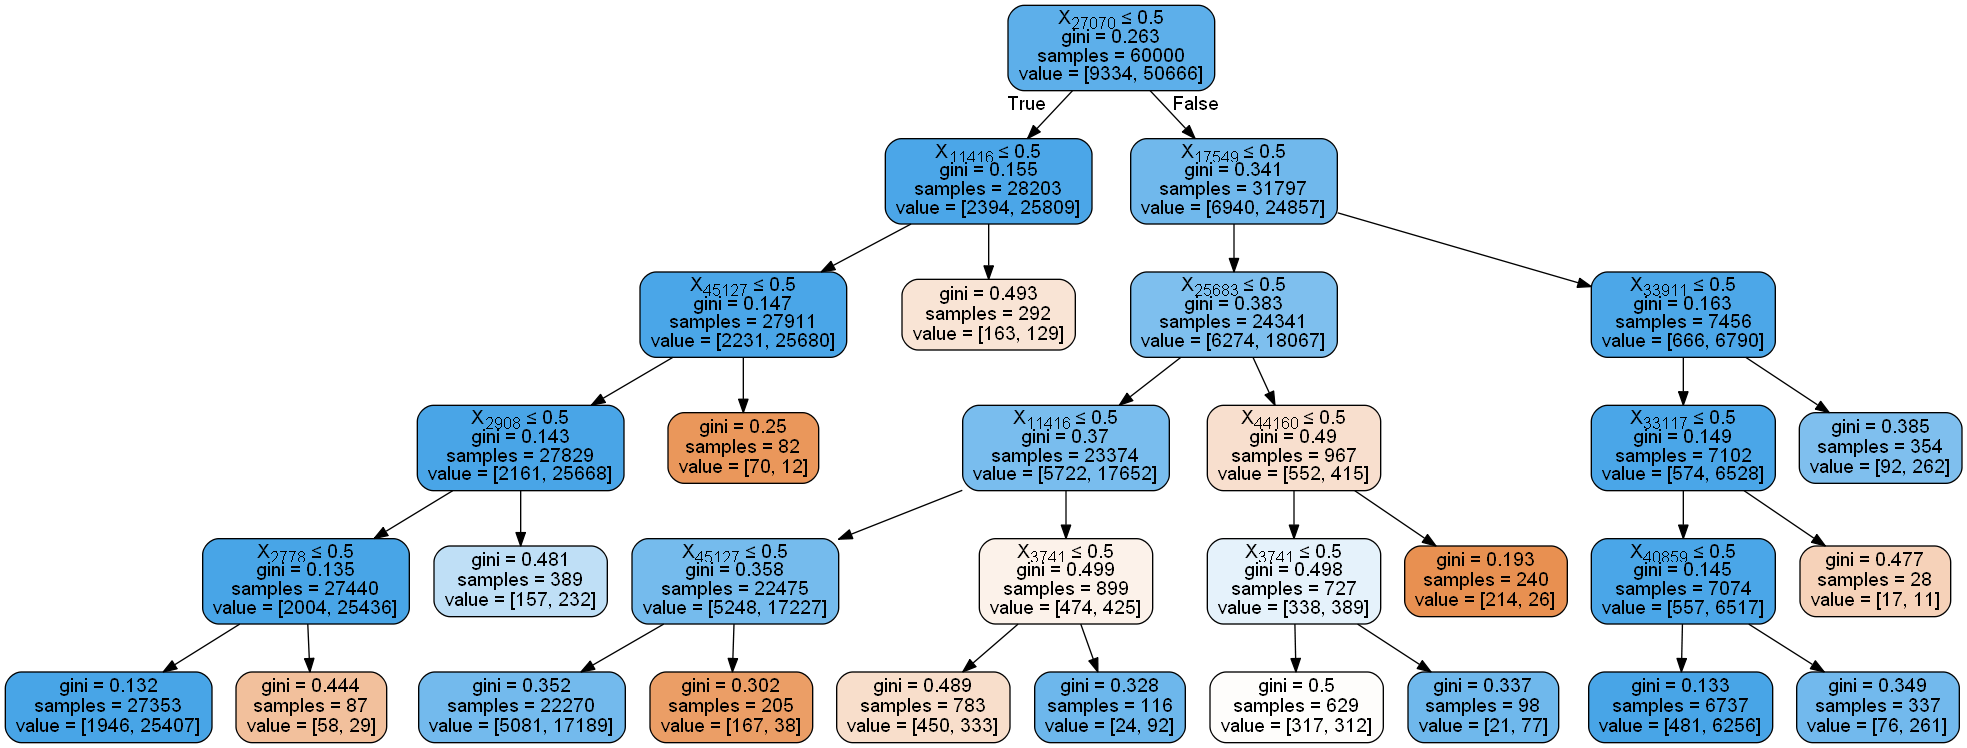

In [77]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

In [45]:
## Create a tf-idf vectorizer-unigram

## For Train data

tf_idf_vect = TfidfVectorizer(ngram_range=(1,1),dtype='float')
tf_idf_vocab=tf_idf_vect.fit(Train_data['CleanedText'].values) ## Create Vocabulary to be used by Train and Test Data
tf_idf_train_counts=tf_idf_vect.transform(Train_data['CleanedText'].values)
tf_idf_train_counts.get_shape()

C:\Users\Gaurav\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:1547: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. float 'dtype' will be converted to np.float64.
  UserWarning)


(60000, 45851)

In [46]:
## For CV data
tf_idf_cv_counts=tf_idf_vect.transform(CV_data['CleanedText'].values)
tf_idf_cv_counts.get_shape()

(20000, 45851)

In [47]:
## For Test data
tf_idf_test_counts=tf_idf_vect.transform(Test_data['CleanedText'].values)
tf_idf_test_counts.get_shape()

(23930, 45851)

###### Find Optimal values of max depth and min split using CV data

In [48]:
optimal_depth,optimal_split,train_auc,optimal_auc=find_optimal_dt_params(tf_idf_train_counts,Y_train_Polarity,tf_idf_cv_counts,CV_data['Score'].values,max_depth,min_samples_split)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [6:31:55<00:00, 4909.19s/it]


For CV Data


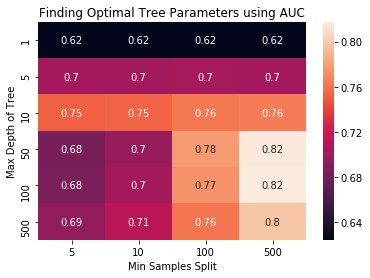

-----------------------------------------------------------------
For Train Data


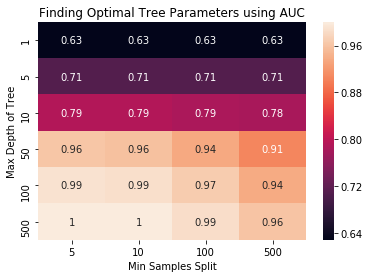

In [49]:
print('For CV Data')
plot_metric(optimal_depth,optimal_split,optimal_auc)
print('-----------------------------------------------------------------')
print('For Train Data')
plot_metric(optimal_depth,optimal_split,train_auc)

###### Check on Test Data

In [116]:
dt_clf=DCT(max_depth=50,min_samples_split=500)
dt_clf.fit(tf_idf_train_counts,Y_train_Polarity)
test_predict=dt_clf.predict_proba(tf_idf_test_counts)
actual_test=Test_data['Score'].values
predicted_test=test_predict[:,1]
predicted_test_class=dt_clf.predict(tf_idf_test_counts)

In [117]:
test_roc=roc_auc_score(actual_test,predicted_test)
print('Test AUC:',test_roc)

Test AUC: 0.8165857692911511


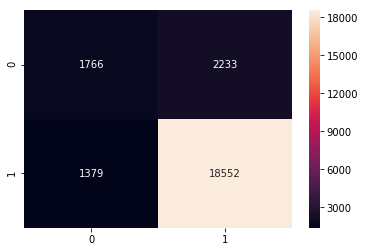

In [118]:
## Plot Confusion Matrix

cm=confusion_matrix(actual_test, predicted_test_class)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d"); #annot=True to annotate cells

In [91]:
fpr,tpr,_=roc_curve(actual_test,predicted_test)

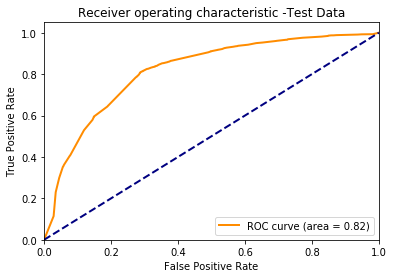

In [92]:
roc_auc_plot(fpr,tpr,test_roc)

In [93]:
imp_feat=dt_clf.feature_importances_

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [94]:
sorted(zip(imp_feat, tf_idf_vect.get_feature_names()), reverse=True)[:20]

[(0.10020296211645774, 'not'),
 (0.05744998093152492, 'great'),
 (0.04554634979717297, 'disappointed'),
 (0.0381595542612406, 'money'),
 (0.038072944670057576, 'worst'),
 (0.029876875422022622, 'best'),
 (0.023724148986480082, 'delicious'),
 (0.020188974521135713, 'threw'),
 (0.019888428953536708, 'awful'),
 (0.01985717428603484, 'good'),
 (0.019163572871840864, 'love'),
 (0.018646646439123, 'bad'),
 (0.017106450044854917, 'return'),
 (0.01436341109944616, 'loves'),
 (0.0136175505683878, 'terrible'),
 (0.013152399557708081, 'perfect'),
 (0.01220231255585143, 'disgusting'),
 (0.011819364417505184, 'waste'),
 (0.011747855085862765, 'horrible'),
 (0.011029746734934382, 'disappointing')]

### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

In [95]:
dt_clf=DCT(max_depth=5,min_samples_split=500)
dt_clf.fit(Train_counts,Y_train_Polarity)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=500,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [96]:
graph = Source(tree.export_graphviz(dt_clf
      , out_file=None
      , feature_names=count_vect.get_feature_names()
      , class_names=['Negative', 'Positive']
      , filled = True))

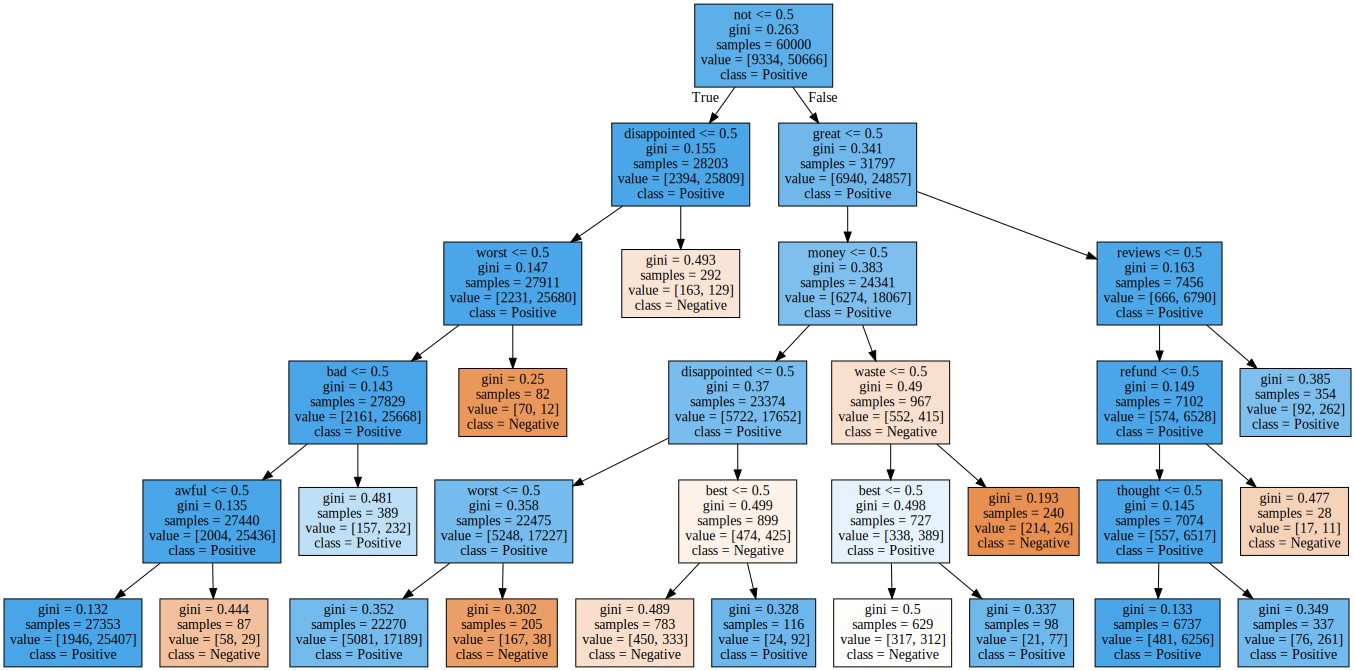

In [97]:
display(SVG(graph.pipe(format='svg')))

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

In [50]:
## Split each text row into words for train data
sent_split_train=[sent.split() for sent in Train_data['CleanedText'].values]
print(sent_split_train[0])

['dogs', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'made', 'china', 'satisfied', 'safe']


In [51]:
## Train Word2Vec Model.Consider words with min frequency 5.

w2vModel=Word2Vec(sent_split_train,min_count=5,size=100,workers=4)

In [52]:
## W2V Train Vocab
w2v_words_train = list(w2vModel.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words_train))
print("sample words ", w2v_words_train[0:50])

number of words that occured minimum 5 times  14660
sample words  ['dogs', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'made', 'china', 'satisfied', 'safe', 'loves', 'chicken', 'product', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'bought', 'local', 'hardware', 'terrible', 'fly', 'problem', 'trapped', 'year', 'still', 'hanging', 'buy', 'many', 'flies', 'house', 'weeks', 'stuck', 'thus', 'far']


In [53]:
## Find Avg Word Vectors for each sentence. Use for both Train,CV and Test Data

def AvgWord2Vec(sent_split):
    '''
    This function takes the sentences from the text and computes avg word vectors.
    input:
    sent_split :List of input sentences split into words for each row of text
    output:
    avg_sent_vectors: List of avg word vectors of dimension 50
    '''
    avg_sent_vectors=[]
    for sent in sent_split:
        sent_vect=np.zeros(100)
        cnt_word=0
        for word in sent:
            if word in w2v_words_train:
                word_vec=w2vModel.wv[word]
                cnt_word+=1
                sent_vect+=word_vec
        if cnt_word != 0:
            sent_vect/=cnt_word
        avg_sent_vectors.append(sent_vect)
    return(avg_sent_vectors)

In [54]:
avg_vectors_train=AvgWord2Vec(sent_split_train)
print(avg_vectors_train[0])

[-0.27355058 -0.10270871  0.1074539   0.28257559  0.43232655 -0.64324737
  0.2781092   0.28470868  0.07658866 -0.2537404   0.0529737   0.12034961
 -0.20609621  0.49144153 -0.44048618 -0.39751772  0.32179723 -0.11572101
 -0.42092537 -0.01564584  0.48746071 -0.30872999 -0.03396849 -0.2676595
  0.01889784 -1.25422449 -0.72025282 -0.1550286  -0.48653475  0.3776949
  0.18809069  0.30145756 -0.00401981 -0.50943725  0.20087964 -0.21122357
  0.80795798 -0.44449436 -0.57456611  0.01457371 -0.06863888  0.25802681
  0.06941531 -0.46766696 -0.399845    0.18911974 -0.25653342 -0.35803994
 -0.41551549 -0.27366907 -0.5304928   0.35905986  0.59324862  0.16192705
  0.59854394  0.38401269  0.32700142 -0.12484295 -0.06785663  0.06671565
 -0.22618597 -0.02502297 -0.5180009  -0.01091607 -0.1334246  -0.8399492
  0.55455668 -0.56913923 -0.56746247 -0.17282707 -0.17629464 -0.40801584
 -0.79909342 -0.38571893 -0.62020253  0.35466174 -0.47024721  0.02243661
  0.32339575 -0.42744237  0.09768879  0.30708004 -0.41

In [55]:
## Split each text row into words for test data
sent_split_cv=[sent.split() for sent in CV_data['CleanedText'].values]
print(sent_split_cv[0])

['buy', 'formula', 'son', 'allergic', 'cow', 'milk', 'possibly', 'soy', 'started', 'enfamil', 'doctor', 'wants', 'stay', 'brand', 'stuff', 'expensive', 'stinks', 'honestly', 'cannot', 'wait', 'not', 'need', 'anymore', 'also', 'colic', 'nothing', 'help', 'colic', 'like', 'says', 'gave', 'stars', 'son', 'needs', 'due', 'allergies']


In [56]:
avg_vectors_cv=AvgWord2Vec(sent_split_cv)
print(avg_vectors_cv[0])

[ 0.08161508 -0.07771063 -0.15018495  0.32482352  0.15114024 -0.0293852
 -0.17068149  0.31820987 -0.03254552 -0.43872774  0.3096624  -0.33154199
 -0.00921599  0.51726075 -0.34834557 -0.43499108  0.16916134  0.55301079
 -0.19038201 -0.31944068 -0.2418234   0.13310742  0.0267475  -0.09061304
 -0.19455174 -0.30254428 -0.4015117  -0.01651258  0.00304332 -0.01154432
 -0.5726512   0.03468981  0.08628635 -0.48804449  0.19259017 -0.11190894
  0.06012302 -0.42847856 -0.39436744 -0.45719853  0.36096027 -0.01473517
 -0.04726306  0.22283044  0.16746708  0.22509543 -0.03301439 -0.41223676
 -0.06080426  0.09832032 -0.18910224 -0.00372155  0.20608346  0.06541817
  0.22441523  0.06603505 -0.00699636 -0.15308475  0.10372402  0.69967523
  0.10166644 -0.09626885 -0.07195597 -0.19698629  0.02029019 -0.20011731
  0.09032196 -0.00158039 -0.5127075  -0.14833633 -0.23242551 -0.19617875
  0.11678356 -0.15041762 -0.39602902  0.42921763 -0.58221515  0.21328639
  0.12756675 -0.13938735 -0.39445287  0.56905518 -0.

In [57]:
## Split each text row into words for test data
sent_split_test=[sent.split() for sent in Test_data['CleanedText'].values]
print(sent_split_test[0])

['favorite', 'bars', 'ever', 'combo', 'raisons', 'dark', 'choc', 'wonderful', 'filling', 'hard', 'find', 'stores', 'thankful', 'subsrcibe', 'save']


In [58]:
avg_vectors_test=AvgWord2Vec(sent_split_test)
print(avg_vectors_test[0])

[ 0.05435721 -0.59201161 -0.37543703  0.5371016  -0.11387363 -0.00667634
 -0.04433014  0.1636048  -0.24764755  0.10105772 -0.05295308  0.02905344
 -0.04316617  0.94005308 -0.03756537 -0.31212728 -0.67040267  0.18925555
 -0.34264954 -0.43261862 -0.50702502 -0.22095002  0.12387577  0.15087842
 -0.86332568 -0.02192838 -0.52396115  0.37488201 -0.25172607  0.19128939
 -0.41447598 -0.21681447  0.56505109  0.04582227 -0.53203725  0.39687466
 -0.04334332 -0.66529999 -0.39699168  0.35933833 -0.54936484  0.26247428
  0.30266163 -0.45183496  0.06670142  0.74396843 -0.02058102  1.16041655
  0.38484373 -0.72985103 -0.23629108 -0.51616379  0.13904228  0.38484209
  0.45256802 -0.77647679  0.07752867  0.37569397 -0.33576574  0.23216083
  0.01838739  0.52468232  0.07623193  0.22390519 -0.09010142 -0.64415857
  0.25808896 -0.10342484 -0.52747909  0.55353728 -0.62311126  0.14657047
 -0.23635541 -0.18879545  0.37362106 -0.74448453 -0.83649534  0.10833879
  0.24663823  0.15539741  0.48159687 -0.41174228  0

In [59]:
len(avg_vectors_train[0])

100

###### Find optimal parameters for decision tree

In [60]:
optimal_depth,optimal_split,train_auc,optimal_auc=find_optimal_dt_params(avg_vectors_train,Y_train_Polarity,avg_vectors_cv,CV_data['Score'].values,max_depth,min_samples_split)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [13:28<00:00, 127.25s/it]


For CV Data


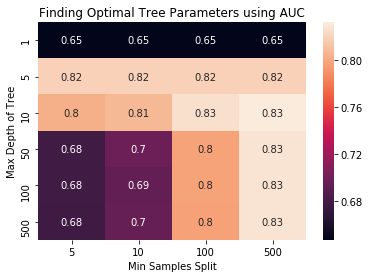

-----------------------------------------------------------------
For Train Data


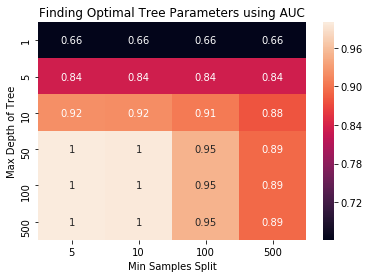

In [61]:
print('For CV Data')
plot_metric(optimal_depth,optimal_split,optimal_auc)
print('-----------------------------------------------------------------')
print('For Train Data')
plot_metric(optimal_depth,optimal_split,train_auc)

In [119]:
dt_clf=DCT(max_depth=10,min_samples_split=500)
dt_clf.fit(avg_vectors_train,Y_train_Polarity)
test_predict=dt_clf.predict_proba(avg_vectors_test)
actual_test=Test_data['Score'].values
predicted_test=test_predict[:,1]
predicted_test_class=dt_clf.predict(avg_vectors_test)

In [120]:
test_roc=roc_auc_score(actual_test,predicted_test)
print('Test AUC:',test_roc)

Test AUC: 0.8257164700085764


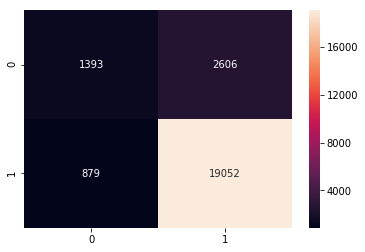

In [121]:
## Plot Confusion Matrix

cm=confusion_matrix(actual_test, predicted_test_class)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d"); #annot=True to annotate cells

In [122]:
fpr,tpr,_=roc_curve(actual_test,predicted_test)

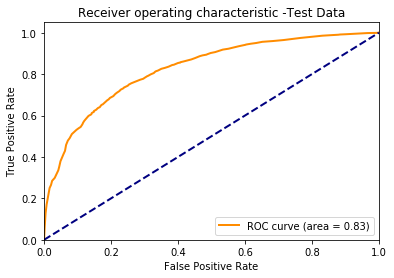

In [123]:
roc_auc_plot(fpr,tpr,test_roc)

## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

In [62]:
# we are converting a dictionary with word as a key, and the idf as a value 
## Code snippet from AAIC notebook

dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [63]:
## Clean '-' from sentences
import re
def clean_wrd(wrd):
    cleanhash=re.compile('-')
    cleanwrd=re.sub(cleanhash,'',wrd)
    return cleanwrd

In [64]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[0:100])

some sample features(unique words in the corpus) ['aa', 'aaa', 'aaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaah', 'aaaah', 'aaaand', 'aaah', 'aachen', 'aadp', 'aafco', 'aahs', 'aap', 'aargh', 'aarthur', 'aarti', 'ab', 'aback', 'abandon', 'abandoned', 'abandoning', 'abbaye', 'abbey', 'abbott', 'abbreviated', 'abbreviation', 'abby', 'abc', 'abcessed', 'abd', 'abdomen', 'abdominal', 'abe', 'abel', 'abeneficial', 'aberration', 'abetter', 'abid', 'abide', 'abiding', 'abig', 'abilities', 'ability', 'abilling', 'abit', 'abita', 'abj', 'ablaze', 'able', 'ablity', 'ablution', 'abnormal', 'abnormalities', 'abnormally', 'abode', 'abolitionists', 'abolutely', 'abolutley', 'abomination', 'abominations', 'aboout', 'abor', 'aborio', 'abosolutely', 'abosoutely', 'abot', 'abottle', 'abou', 'aboulutely', 'abound', 'abounds', 'abour', 'aboutamazon', 'aboutone', 'aboutthe', 'abovei', 'abovementioned', 'abowl', 'abowt', 'abrasion', 'abrasive', 'abroad', 'abrupt', 'abruptly', 'abruptness', 'abruzzi', 'abr

In [65]:
def AvgWord2Vectfidf(sent_split):
    '''
    This function takes the sentences from the text and tf idf counts and computes tf idf weighted word vectors.
    input:
    sent_split :List of input sentences split into words for each row of text and tf idf counts
    output:
    tf_idf_sent_vectors: List of tf idf weighted word vectors of dimension 50
    '''
    tf_idf_sent_vectors=[]
    for sent in sent_split:
        sent_vec=np.zeros(100)
        weight_sum=0
        for word in sent:
            word=clean_wrd(word)
            if word in w2v_words_train:
                word_vec=w2vModel.wv[word]
                try:
                    #tf_idf = tf_idf_counts[row, features.index(word)]
                    tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                    sent_vec += (word_vec * tf_idf)
                    weight_sum += tf_idf
                except:
                    continue
        if weight_sum != 0:
            sent_vec/=weight_sum
        tf_idf_sent_vectors.append(sent_vec)
    return(tf_idf_sent_vectors)

In [66]:
tf_idf_vectors_train=AvgWord2Vectfidf(sent_split_train)
print(len(tf_idf_vectors_train))

60000


In [67]:
tf_idf_vectors_cv=AvgWord2Vectfidf(sent_split_cv)
print(len(tf_idf_vectors_cv))

20000


In [68]:
tf_idf_vectors_test=AvgWord2Vectfidf(sent_split_test)
print(len(tf_idf_vectors_test))

23930


###### Find optimal parameters for decision tree

In [69]:
optimal_depth,optimal_split,train_auc,optimal_auc=find_optimal_dt_params(tf_idf_vectors_train,Y_train_Polarity,tf_idf_vectors_cv,CV_data['Score'].values,max_depth,min_samples_split)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [12:01<00:00, 119.06s/it]


For CV Data


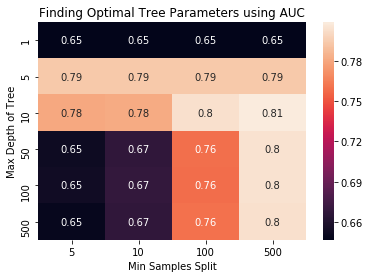

-----------------------------------------------------------------
For Train Data


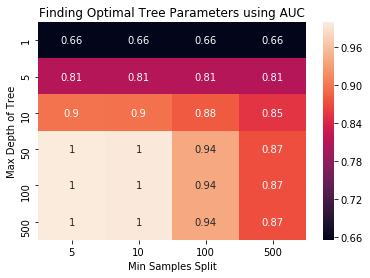

In [70]:
print('For CV Data')
plot_metric(optimal_depth,optimal_split,optimal_auc)
print('-----------------------------------------------------------------')
print('For Train Data')
plot_metric(optimal_depth,optimal_split,train_auc)

In [133]:
dt_clf=DCT(max_depth=10,min_samples_split=500)
dt_clf.fit(tf_idf_vectors_train,Y_train_Polarity)
test_predict=dt_clf.predict_proba(tf_idf_vectors_test)
actual_test=Test_data['Score'].values
predicted_test=test_predict[:,1]
predicted_test_class=dt_clf.predict(tf_idf_vectors_test)

In [134]:
test_roc=roc_auc_score(actual_test,predicted_test)
print('Test AUC:',test_roc)

Test AUC: 0.7841105703147978


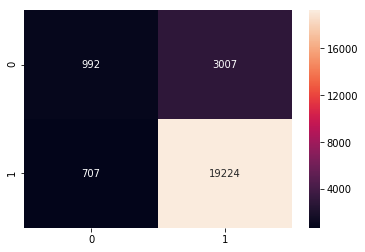

In [135]:
## Plot Confusion Matrix

cm=confusion_matrix(actual_test, predicted_test_class)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d"); #annot=True to annotate cells

In [136]:
fpr,tpr,_=roc_curve(actual_test,predicted_test)

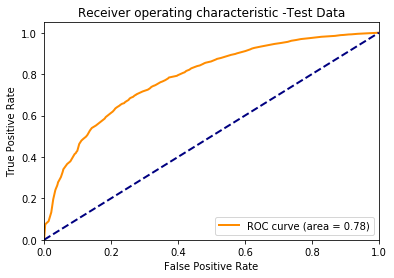

In [137]:
roc_auc_plot(fpr,tpr,test_roc)

# [6] Conclusions

In [138]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Featurisation",'Max Depth','Min Samples Split', "AUC"]
x.add_row(["BOW", 50,500,0.83])
x.add_row(["TFIDF", 50,500,0.82])
x.add_row(["AVG W2Vec", 100,500,0.83])
x.add_row(["TFIDF W2Vec", 10,500,0.78])
print(x)

+---------------+-----------+-------------------+------+
| Featurisation | Max Depth | Min Samples Split | AUC  |
+---------------+-----------+-------------------+------+
|      BOW      |     50    |        500        | 0.83 |
|     TFIDF     |     50    |        500        | 0.82 |
|   AVG W2Vec   |    100    |        500        | 0.83 |
|  TFIDF W2Vec  |     10    |        500        | 0.78 |
+---------------+-----------+-------------------+------+


Thus we see that in general the performance of decision trees on our text data is poor compared to the other modelling techniques that we saw until now.  
For decision trees, BOW and Avg Word2Vec perform slightly better than other featurisations.

###### Experiment with some more features

Lets use some more features and see if the auc improves. We will do it for BOW model.

In [139]:
## Create a feature for length of the reviews
review_length_train=Train_data['CleanedText'].apply(len)
print(review_length_train.head())

22621     72
22620    162
70689    109
70674     49
70693    301
Name: CleanedText, dtype: int64


In [140]:
## Create a feature for length of the summary
summary_length_train=Train_data['Summary'].apply(len)
print(summary_length_train.head())

22621     17
22620     13
70689     17
70674    108
70693     40
Name: Summary, dtype: int64


In [141]:
# Combine features
# Refer :https://sondosatwi.wordpress.com/2017/08/01/using-text-data-and-dataframemapper-in-python/
Train_data['review_length']=review_length_train
Train_data['summary_length']=summary_length_train
Train_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,review_length,summary_length
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...,72,17
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...,162,13
70689,76883,B00002N8SM,A29GWIJL72GXXZ,jon123,1,2,0,1270771200,ONLY CAUGHT 1 FLY,Bought at my local Hardware Store. I was havi...,bought local hardware store terrible fly probl...,109,17
70674,76867,B00002N8SM,A1VSEBVZS81UCI,Brian Haynes,0,0,0,1314748800,We have so many flies in the house. Have had ...,We have so many flies in the house. Have had ...,many flies house product weeks stuck fly thus far,49,108
70693,76888,B00002N8SM,A1L227LG53GTLB,M. A.,2,4,0,1171843200,Regular fly ribbon worked way better ...,In the time I spent waiting for my order of th...,time spent waiting order fly traps arrive went...,301,40


In [142]:
from sklearn_pandas import DataFrameMapper, cross_val_score

In [143]:
#Add the features of the dataframe that you want to transform and/or combine
mapper = DataFrameMapper([
     ('CleanedText', CountVectorizer()),
     ('review_length', None),
     ('summary_length', None),
 ],sparse=True)

In [144]:
train_features = mapper.fit_transform(Train_data)

In [145]:
## Create Similar Features for CV and Test Data
CV_data['review_length']=CV_data['CleanedText'].apply(len)
CV_data['summary_length']=CV_data['Summary'].apply(len)
####
Test_data['review_length']=Test_data['CleanedText'].apply(len)
Test_data['summary_length']=Test_data['Summary'].apply(len)

In [146]:
cv_features=mapper.transform(CV_data)
test_features=mapper.transform(Test_data)

In [150]:
## Fit on Test Data
dt_clf=DCT(max_depth=50,min_samples_split=500)
dt_clf.fit(train_features,Y_train_Polarity)
test_predict=dt_clf.predict_proba(test_features)
actual_test=Test_data['Score'].values
predicted_test=test_predict[:,1]

In [151]:
test_roc=roc_auc_score(actual_test,predicted_test)
print('Test AUC:',test_roc)

Test AUC: 0.8249905095811356


The auc does not improve with added features.